In [ ]:
# !pip install mediapipe

In [63]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [64]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [65]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [66]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [67]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [68]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [69]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [70]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [71]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [72]:
# !pip install moviepy

In [73]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [74]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [75]:
label_map = {label:num for num, label in enumerate(actions)}

In [76]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [77]:
DATA_PATH

'data2'

In [78]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [79]:
np.array(sequences).shape

(450, 30, 1662)

In [80]:
np.array(labels).shape

(450,)

In [81]:
X = np.array(sequences)

In [82]:
X.shape

(450, 30, 1662)

In [83]:
y = to_categorical(labels).astype(int)

In [84]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [86]:
y_test.shape

(23, 6)

## Build Network

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [88]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [89]:
import tensorflow as tf

In [90]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [91]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [92]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.033333335>

In [93]:
def Reward(y_true, y_pred, external_metric, attention_scores):
    correct_predictions = tf.reduce_sum(y_true * y_pred) * (1 + tf.math.log1p(external_metric)) / (1 + tf.math.exp(-tf.reduce_mean(y_pred)))

    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2) * (1 - tf.reduce_mean(attention_scores)) * tf.math.exp(-tf.reduce_mean(y_pred))

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]) * attention_scores * tf.math.log1p(tf.reduce_sum(y_true, axis=0)))

    external_metric_bonus = 0.4 * tf.math.exp(external_metric) / (1 + tf.math.exp(-tf.reduce_mean(y_pred)))
    average_attention_score = tf.sqrt(tf.reduce_mean(attention_scores)) * tf.math.log1p(tf.reduce_mean(y_pred))

    term = 0.2 * external_metric * tf.math.exp(-tf.reduce_mean(y_pred)) + 0.3 * tf.reduce_mean(tf.square(attention_scores) * tf.math.log1p(tf.reduce_sum(y_true, axis=0)))

    temporal_regularization = tf.math.exp(-tf.reduce_mean(y_pred))
    spatial_regularization = tf.math.exp(-tf.norm(mean_pred_axis_0, ord=2))

    reward = correct_predictions - 0.1 * diversity_penalty - 0.3 * weighted_mistakes_penalty + external_metric_bonus + 0.2 * average_attention_score + term + temporal_regularization + spatial_regularization

    return reward


In [94]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    external_metric = 0.5
    
    reward = Reward(y_true, y_pred, external_metric, average_attention_score)
    
    return loss - 0.1 * reward

In [95]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [96]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [97]:
X_train.shape,y_train.shape

((427, 30, 1662), (427, 6))

In [101]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
14/14 [==============================] - 4s 186ms/step - loss: -0.7842 - categorical_accuracy: 0.6768
Epoch 2/50
14/14 [==============================] - 3s 183ms/step - loss: -0.7990 - categorical_accuracy: 0.6464
Epoch 3/50
14/14 [==============================] - 2s 176ms/step - loss: -0.8938 - categorical_accuracy: 0.6674
Epoch 4/50
14/14 [==============================] - 3s 196ms/step - loss: -0.9824 - categorical_accuracy: 0.6651
Epoch 5/50
14/14 [==============================] - 2s 176ms/step - loss: -1.0511 - categorical_accuracy: 0.6979
Epoch 6/50
14/14 [==============================] - 3s 182ms/step - loss: -0.9961 - categorical_accuracy: 0.6768
Epoch 7/50
14/14 [==============================] - 3s 195ms/step - loss: -1.0092 - categorical_accuracy: 0.6979
Epoch 8/50
14/14 [==============================] - 3s 177ms/step - loss: -1.1411 - categorical_accuracy: 0.7213
Epoch 9/50
14/14 [==============================] - 3s 189ms/step - loss: -1.1371 - categorical_

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 128)           916992    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


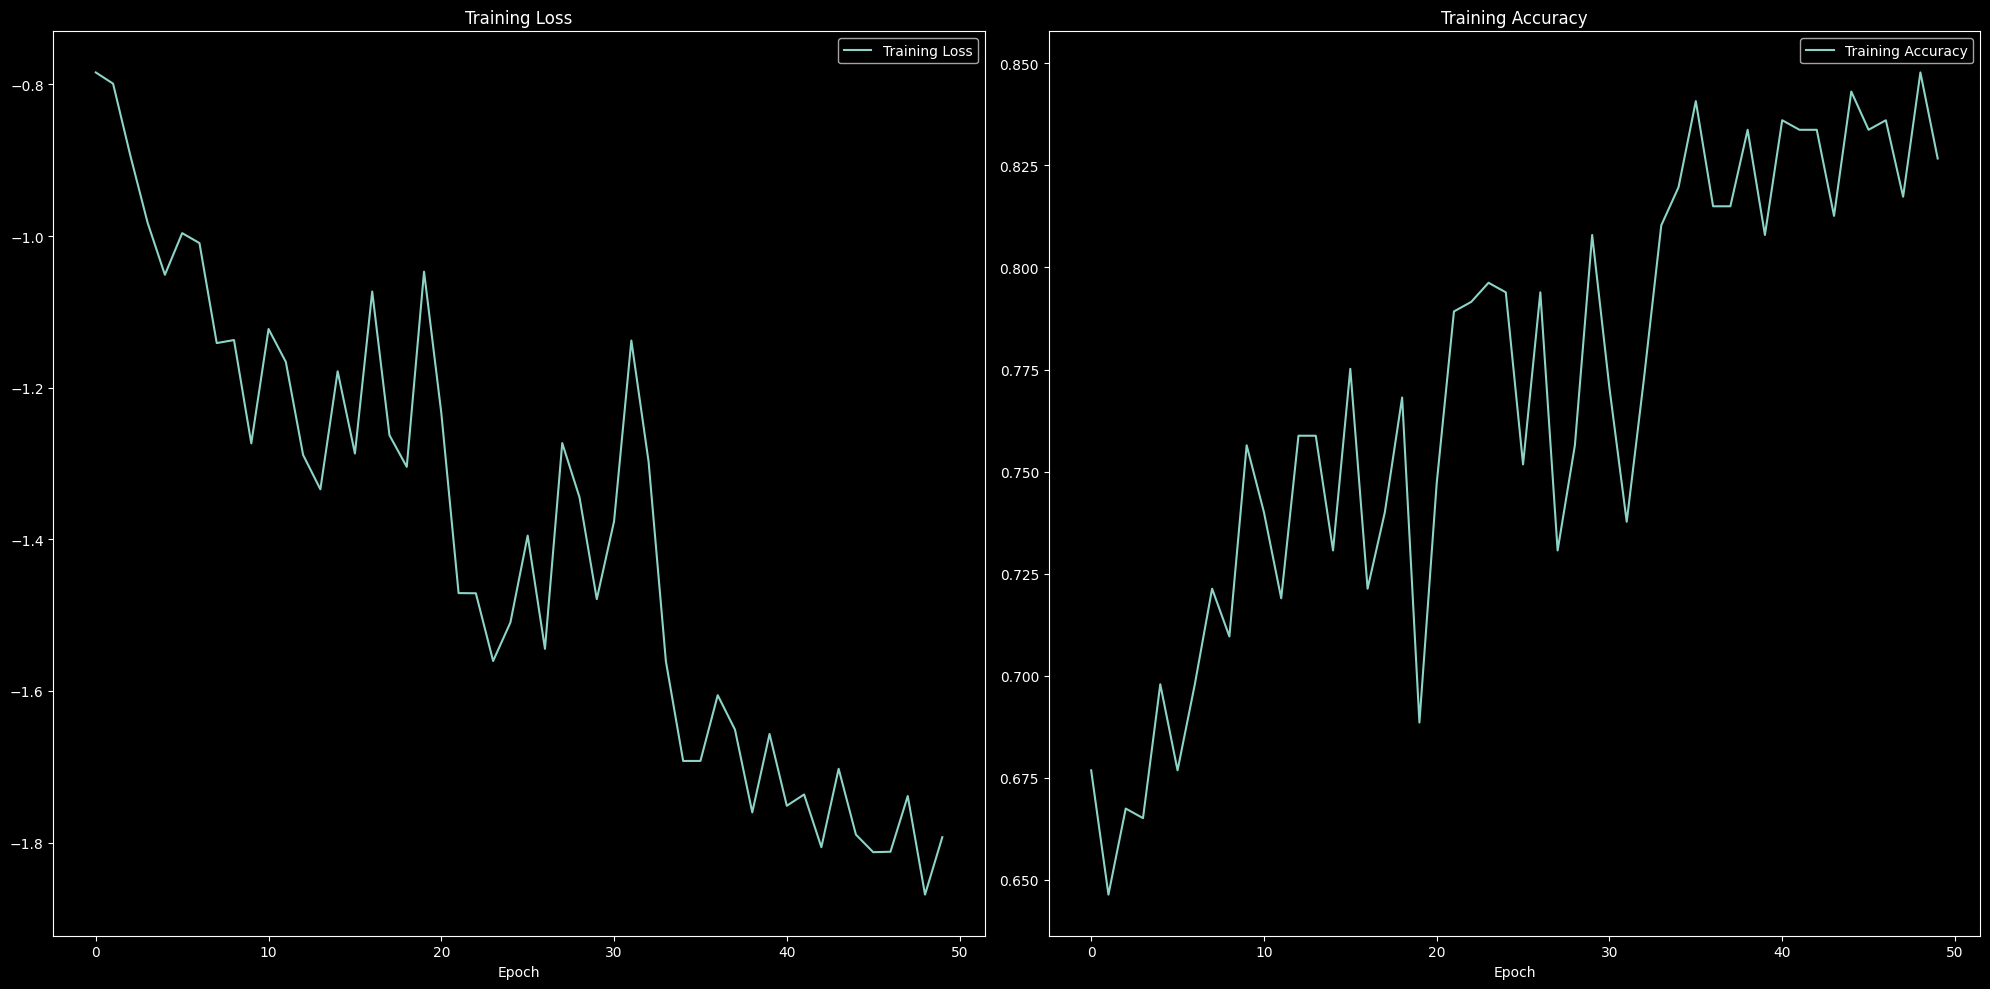

In [103]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [104]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [105]:
y_p.shape

(23, 6)

In [106]:
y_test.shape

(23, 6)

In [107]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [108]:
# calculate_reward(y_test,y_p)

In [109]:
res = model.predict(X_test)

1/1 [==============================] - 0s 81ms/step


In [70]:
X_test

array([[[ 0.60634059,  0.55491072, -1.04024255, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60117257,  0.55490822, -1.0157721 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.59768188,  0.55494666, -1.03387845, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.60330266,  0.54476851, -1.28660083, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60203284,  0.54442257, -1.149984  , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60027808,  0.54426688, -1.0694108 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.60645151,  0.61626238, -1.15339303, ...,  0.52011323,
          0.26790157, -0.10483942],
        [ 0.60764229,  0.6159302 , -1.16599894, ...,  0.52408683,
          0.28885972, -0.11469182],
        [ 0.60876948,  0.64212555, -1.16197801, ...,  0.53268039,
          0.31843147, -0.12967503],
        ...,
        [ 0.6256153 ,  0.67288744, -1.43679106, ...,  

In [110]:
res

array([[2.74427875e-04, 1.77437775e-02, 4.84902225e-03, 1.13621623e-09,
        2.18544505e-03, 9.74947393e-01],
       [2.82035646e-04, 1.42436125e-04, 9.99069750e-01, 4.13781527e-06,
        1.37435245e-06, 5.00234193e-04],
       [6.97350034e-12, 3.58848760e-19, 2.29978482e-18, 1.00000000e+00,
        1.43974182e-15, 5.89442774e-12],
       [1.08138556e-06, 9.89667296e-01, 9.97193856e-04, 5.85991611e-09,
        8.01187195e-03, 1.32252323e-03],
       [7.35950016e-05, 3.94492030e-01, 2.89166725e-04, 2.81317567e-04,
        6.04718208e-01, 1.45693644e-04],
       [6.31062430e-04, 5.72062612e-01, 3.82937817e-03, 1.93236163e-04,
        4.23263788e-01, 1.98781672e-05],
       [1.55684775e-05, 4.60578604e-14, 2.23151417e-08, 9.99984384e-01,
        2.95787318e-11, 2.95344504e-09],
       [1.26580335e-03, 2.56375552e-05, 9.98650372e-01, 4.31930239e-05,
        4.27242048e-06, 1.07672740e-05],
       [2.43749295e-04, 3.61259244e-02, 4.16481867e-03, 6.93987701e-10,
        6.50755735e-03, 

In [111]:
actions[np.argmax(res[6])]

'neutral'

In [112]:
actions[np.argmax(y_test[6])]

'neutral'

In [114]:
model.save('action_with_Reward_5_v2.h5')
model.save_weights('action_with_Reward_5_weights_v2.h5')

H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
import tensorflow as tf

In [116]:
model = tf.keras.models.load_model("action_with_Reward_5_v2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [313]:
_, test1, _, test1_label = train_test_split(X, y, test_size=0.30)

In [314]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [315]:
yhat = model.predict(test1)

5/5 [==============================] - 1s 98ms/step


In [316]:
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [317]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[110,   1],
        [  3,  21]],

       [[108,   7],
        [  5,  15]],

       [[114,   2],
        [  0,  19]],

       [[110,   3],
        [  0,  22]],

       [[104,   5],
        [  7,  19]],

       [[111,   0],
        [  3,  21]]], dtype=int64)

In [318]:
accuracy_score(ytrue, yhat)

0.8666666666666667

In [326]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(ytrue,yhat))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.68      0.75      0.71        20
           2       0.90      1.00      0.95        19
           3       0.88      1.00      0.94        22
           4       0.79      0.73      0.76        26
           5       1.00      0.88      0.93        24

    accuracy                           0.87       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135



In [123]:
for num, prob in enumerate(res):
    print(num,prob)

0 [2.7442788e-04 1.7743777e-02 4.8490223e-03 1.1362162e-09 2.1854450e-03
 9.7494739e-01]
1 [2.8203565e-04 1.4243613e-04 9.9906975e-01 4.1378153e-06 1.3743525e-06
 5.0023419e-04]
2 [6.9735003e-12 3.5884876e-19 2.2997848e-18 1.0000000e+00 1.4397418e-15
 5.8944277e-12]
3 [1.0813856e-06 9.8966730e-01 9.9719386e-04 5.8599161e-09 8.0118719e-03
 1.3225232e-03]
4 [7.3595002e-05 3.9449203e-01 2.8916672e-04 2.8131757e-04 6.0471821e-01
 1.4569364e-04]
5 [6.3106243e-04 5.7206261e-01 3.8293782e-03 1.9323616e-04 4.2326379e-01
 1.9878167e-05]
6 [1.5568477e-05 4.6057860e-14 2.2315142e-08 9.9998438e-01 2.9578732e-11
 2.9534450e-09]
7 [1.2658034e-03 2.5637555e-05 9.9865037e-01 4.3193024e-05 4.2724205e-06
 1.0767274e-05]
8 [2.4374929e-04 3.6125924e-02 4.1648187e-03 6.9398770e-10 6.5075574e-03
 9.5295799e-01]
9 [1.9338063e-04 1.0435895e-01 8.8316257e-05 4.0061980e-08 8.9535081e-01
 8.5692127e-06]
10 [8.1638438e-01 5.1344628e-03 4.5404714e-02 4.2573459e-04 1.3265052e-01
 2.0670484e-07]
11 [1.0422933e-03 1.

In [124]:
from scipy import stats

In [125]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        probability_text = f"{prob * 100:.4f}"  # Format probability to display up to 4 decimal points
        label_text = actions[num]
        cv2.putText(output_frame, f"{label_text}: {probability_text}", (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [126]:
# prob_viz(res[0], actions, image, colors)

In [127]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [128]:
import tensorflow as tf

In [130]:
model = tf.keras.models.load_model("action_with_Reward_5_v2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [131]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("../happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

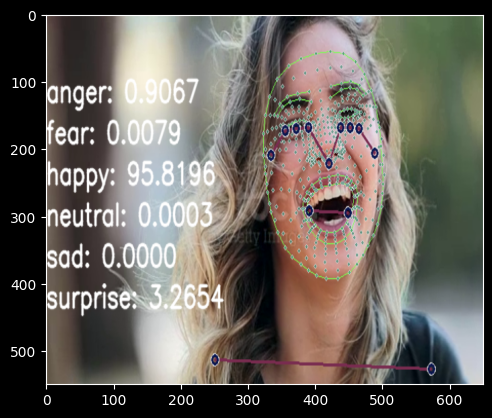

In [132]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [133]:
# history

In [134]:
res

array([9.0667233e-03, 7.9006466e-05, 9.5819640e-01, 3.4859286e-06,
       2.7021213e-07, 3.2654215e-02], dtype=float32)

In [135]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.009066723
fear ----> 7.9006466e-05
happy ----> 0.9581964
neutral ----> 3.4859286e-06
sad ----> 2.7021213e-07
surprise ----> 0.032654215


In [198]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 2 elements:", top_indices)

Indices of the top 2 elements: [2 0]


In [199]:
ans=[]

In [138]:
for i in top_indices:
    ans.append(actions[i])

In [139]:
ans

['happy', 'surprise']

In [101]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
                       # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [102]:
res

array([0.00244456, 0.5239936 , 0.00437142, 0.00655857, 0.45052278,
       0.01210904], dtype=float32)

In [103]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.0024445613
fear ----> 0.5239936
happy ----> 0.0043714233
neutral ----> 0.0065585705
sad ----> 0.45052278
surprise ----> 0.012109045


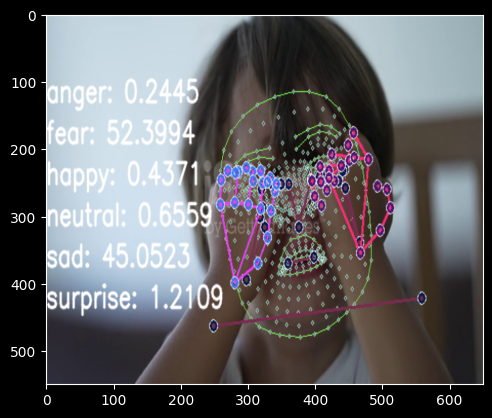

In [105]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [207]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/Body movement data/armflapping-20230830T060845Z-001/armflapping/AMF0.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        brightness_increase = 20  # You can adjust this value as needed
        brightened_image = cv2.add(frame, brightness_increase)

        #Sharp
        kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])
        frame = cv2.filter2D(brightened_image, -1, kernel)

        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(res)
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # image = prob_viz(res, actions, image, colors)
        
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [208]:
res

array([5.9810183e-03, 5.9252902e-04, 9.9152559e-01, 1.2379622e-03,
       1.7790972e-04, 4.8489860e-04], dtype=float32)

In [209]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 0.005981018301099539
fear ----> 0.0005925290170125663
happy ----> 0.9915255904197693
neutral ----> 0.0012379621621221304
sad ----> 0.00017790972196962684
surprise ----> 0.0004848985990975052


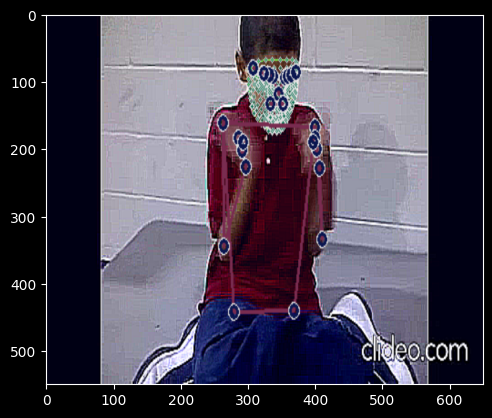

In [210]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [211]:
# J:/AUTISM DETECTION PROJECT/Body movement data/armflapping-20230830T060845Z-001/armflapping/AMF0.mp4

In [212]:
predictions

[array([8.9599240e-01, 9.1302005e-04, 3.0050348e-02, 6.6788867e-02,
        5.7427129e-03, 5.1263545e-04], dtype=float32),
 array([8.8785130e-01, 1.1456206e-03, 4.0430203e-02, 6.4071402e-02,
        5.7272371e-03, 7.7426468e-04], dtype=float32),
 array([0.87932044, 0.00147665, 0.05265917, 0.05930844, 0.00624171,
        0.00099361], dtype=float32),
 array([0.8720444 , 0.00276469, 0.07071577, 0.04377005, 0.00967273,
        0.00103247], dtype=float32),
 array([9.0312022e-01, 1.9100173e-03, 4.6656597e-02, 4.0047385e-02,
        7.4258321e-03, 8.3990162e-04], dtype=float32),
 array([9.1666877e-01, 1.5353281e-03, 3.6496289e-02, 3.8271103e-02,
        6.2925820e-03, 7.3601661e-04], dtype=float32),
 array([0.8649742 , 0.00349924, 0.09042411, 0.02989625, 0.01021726,
        0.00098901], dtype=float32),
 array([0.77867043, 0.00592634, 0.17643054, 0.02464181, 0.01316429,
        0.00116661], dtype=float32),
 array([0.70142365, 0.006972  , 0.25187168, 0.02388316, 0.01466171,
        0.00118782],

In [214]:
answerArr=[]

cnt=1
for i in predictions:
    if(cnt%2==0):
        ind=np.argsort(i)[-2:][::-1]
        temp={'frame':cnt-1,actions[0]:i[0],actions[1]:i[1],actions[2]:i[2],actions[3]:i[3],actions[4]:i[4],actions[5]:i[5],'MAX1':actions[ind[0]],'MAX2':actions[ind[1]]}
        answerArr.append(temp)
    cnt+=1

In [215]:
answerArr

[{'frame': 2,
  'anger': 0.8878513,
  'fear': 0.0011456206,
  'happy': 0.040430203,
  'neutral': 0.0640714,
  'sad': 0.005727237,
  'surprise': 0.0007742647,
  'MAX1': 'anger',
  'MAX2': 'neutral'},
 {'frame': 4,
  'anger': 0.8720444,
  'fear': 0.002764687,
  'happy': 0.07071577,
  'neutral': 0.043770045,
  'sad': 0.00967273,
  'surprise': 0.001032472,
  'MAX1': 'anger',
  'MAX2': 'happy'},
 {'frame': 6,
  'anger': 0.9166688,
  'fear': 0.0015353281,
  'happy': 0.03649629,
  'neutral': 0.038271103,
  'sad': 0.006292582,
  'surprise': 0.0007360166,
  'MAX1': 'anger',
  'MAX2': 'neutral'},
 {'frame': 8,
  'anger': 0.77867043,
  'fear': 0.0059263436,
  'happy': 0.17643054,
  'neutral': 0.024641808,
  'sad': 0.01316429,
  'surprise': 0.0011666118,
  'MAX1': 'anger',
  'MAX2': 'happy'},
 {'frame': 10,
  'anger': 0.64103067,
  'fear': 0.0062643774,
  'happy': 0.31265676,
  'neutral': 0.025988141,
  'sad': 0.012867655,
  'surprise': 0.0011923776,
  'MAX1': 'anger',
  'MAX2': 'happy'},
 {'frame

In [216]:
import pandas as pd
pd.DataFrame(answerArr)

,frame,anger,fear,happy,neutral,sad,surprise,MAX1,MAX2
0,2,0.887851,0.001146,0.040430,0.064071,0.005727,0.000774,anger,neutral
1,4,0.872044,0.002765,0.070716,0.043770,0.009673,0.001032,anger,happy
2,6,0.916669,0.001535,0.036496,0.038271,0.006293,0.000736,anger,neutral
3,8,0.778670,0.005926,0.176431,0.024642,0.013164,0.001167,anger,happy
4,10,0.641031,0.006264,0.312657,0.025988,0.012868,0.001192,anger,happy
5,12,0.554294,0.004521,0.398204,0.032625,0.009302,0.001054,anger,happy
6,14,0.501102,0.002809,0.441667,0.047465,0.005963,0.000996,anger,happy
7,16,0.393388,0.001957,0.538696,0.060842,0.004161,0.000957,happy,anger
8,18,0.207875,0.001814,0.737511,0.048352,0.003561,0.000888,happy,anger
9,20,0.107414,0.001642,0.853814,0.033533,0.002811,0.000787,happy,anger
